# GRU를 이용해 기온 예측하기
## Jena climate 데이터셋 준비

In [1]:
import os

data_dir = '../datasets/jena_climate/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

### 데이터 파싱하기
데이터 전체를 넘파이 배열로 바꾸기

In [2]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

### 시계열 온도 그래프 그리기
주기성을 확인할 수 있다.

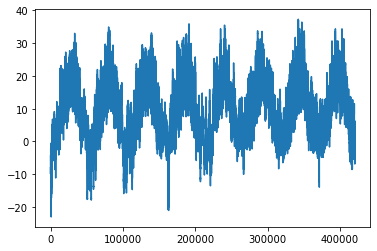

In [3]:
from matplotlib import pyplot as plt
temp = float_data[:, 1]  # 온도(섭씨)
plt.plot(range(len(temp)), temp)
plt.show()

### 처음 10일간의 온도 그래프 그리기
일별 주기성 확인할 수 있다!(밤에 추워..)

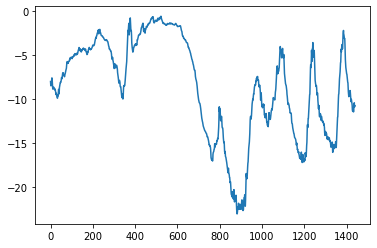

In [4]:
plt.plot(range(1440), temp[:1440])
plt.show()

### 데이터 정규화
데이터에 있는 각 시계열 특성의 범위가 서로 다르므로(ex) 온도: 일반적으로 -20도에서 +30도 사이, 기압(mb):은 1,000 근처) 각 시계열 특성을 개별적으로 정규화하여 비슷한 범위를 가진 작은 값으로 바꾸기  
각 특성에 대해 평균을 빼고 표준편차로 나누기

In [5]:
# 처음 200,000개 타임스텝을 훈련 데이터로 사용할 것이므로 전체 데이터에서 200,000개만 사용하여 평균과 표준 편차를 계산
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

### 제너레이터 함수
```(samples, targets)``` 튜플을 반복적으로 반환  
* ```samples```: 입력 데이터로 사용할 배치
* ```targets```: 타깃 온도의 배열
* 사용 변수
    * ```lookback``` = 1440 : 10일 전 데이터로 돌아가기
    * ```steps``` = 6 : 한 시간마다 데이터 포인트 하나를 샘플링
    * ```delay``` = 144 : 24시간이 지난 데이터를 타깃으로
* 매개변수
    * ```data``` : 코드 6-32에서 정규화한 부동 소수 데이터로 이루어진 원본 배열
    * ```lookback``` : 입력으로 사용하기 위해 거슬러 올라갈 타임스텝
    * ```delay``` : 타깃으로 사용할 미래의 타임스텝
    * ```min_index```, ```max_index``` : 추출할 타임스텝의 범위를 지정하기 위한 data 배열의 인덱스. 검증 데이터와 테스트 데이터를 분리하는 데 사용.
    * ```shuffle``` : 샘플을 섞을지 시간 순서대로 추출할지 결정
    * ```batch_size``` : 배치의 샘플 수
    * ```step``` : 데이터를 샘플링할 타임스텝 간격 (1시간에 1개의 데이터 포인트를 추출하기 위해 6으로 지정)

In [6]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

generator 함수를 사용해 훈련용, 검증용, 테스트용으로 세 개의 제너레이터를 만들기   
각 제너레이터는 원본 데이터에서 다른 시간대를 사용.   
* 훈련 제너레이터: 처음 200,000개 타임스텝 사용하고 
* 검증 제너레이터: 그 다음 100,000개 
* 테스트 제너레이터: 나머지

In [7]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수
val_steps = (300000 - 200001 - lookback) // batch_size

# 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
test_steps = (len(float_data) - 300001 - lookback) // batch_size

### 상식 수준의 기준점 설정
GRU 모델 성능 비교를 위한 상식수준 기준점  
온도 시계열 데이터: 연속성 + 일자별 주기성 있음을 가정(오늘 온도는 내일 온도와 비슷할 가능성이 높다)  
지금으로부터 24시간 후의 온도는 지금과 동일하다고 예측

In [8]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    return np.mean(batch_maes)
    
print("%.2f°C" %(evaluate_naive_method()* std[1]))

2.56°C


## GRU 모델로 학습하기

In [9]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Metal device set to: Apple M1
Epoch 1/20


2022-03-31 13:14:17.843873: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-31 13:14:17.843994: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/var/folders/9_/z_nr8_hd32x51b1zx2flsn080000gn/T/ipykernel_13941/2820699998.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,
2022-03-31 13:14:17.993086: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-31 13:14:18.640123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.c

500/500 [==============================] - ETA: 0s - loss: 0.3037

2022-03-31 13:14:42.932113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-31 13:14:42.968627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


500/500 [==============================] - 39s 74ms/step - loss: 0.3037 - val_loss: 0.2711
Epoch 2/20
500/500 [==============================] - 37s 73ms/step - loss: 0.2830 - val_loss: 0.2641
Epoch 3/20
500/500 [==============================] - 37s 74ms/step - loss: 0.2774 - val_loss: 0.2690
Epoch 4/20
500/500 [==============================] - 37s 74ms/step - loss: 0.2716 - val_loss: 0.2642
Epoch 5/20
500/500 [==============================] - 37s 75ms/step - loss: 0.2680 - val_loss: 0.2603
Epoch 6/20
500/500 [==============================] - 37s 75ms/step - loss: 0.2639 - val_loss: 0.2632
Epoch 7/20
500/500 [==============================] - 150s 300ms/step - loss: 0.2603 - val_loss: 0.2614
Epoch 8/20
500/500 [==============================] - 37s 74ms/step - loss: 0.2548 - val_loss: 0.2647
Epoch 9/20
500/500 [==============================] - 37s 75ms/step - loss: 0.2498 - val_loss: 0.2642
Epoch 10/20
500/500 [==============================] - 38s 76ms/step - loss: 0.2476 - val_l

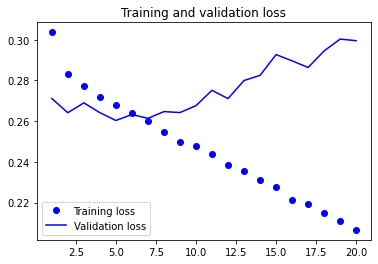

In [10]:
from matplotlib import pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [29]:
print("%.2f°C" %(std[1]*np.min(val_loss)))
print(np.min(val_loss))

2.30°C
0.2603129744529724


MAE: 0.260(2.30°C) *과대적합되기 시작하는 곳 기준*

In [12]:
score = model.evaluate_generator(test_gen, 
                                 steps=test_steps, 
                                 verbose=1)
print("%.2f°C" %(std[1]*score))

  7/930 [..............................] - ETA: 18s - loss: 0.3474

/var/folders/9_/z_nr8_hd32x51b1zx2flsn080000gn/T/ipykernel_13941/2028799216.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(test_gen,


930/930 [==============================] - 18s 19ms/step - loss: 0.3295
2.92°C


Test MAE: 2.92°C

In [13]:
model.save_weights('jena_climate_GRU.h5')

### 완전연결모델과 성능 비교

In [15]:
model2 = Sequential()
model2.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model2.add(layers.Dense(32, activation='relu'))
model2.add(layers.Dense(1))

model2.compile(optimizer=RMSprop(), loss='mae')
history2 = model2.fit_generator(train_gen,
                                steps_per_epoch=500,
                                epochs=20,
                                validation_data=val_gen,
                                validation_steps=val_steps)

score2 = model2.evaluate_generator(test_gen, 
                                   steps=test_steps, 
                                   verbose=1)
print("%.2f°C" %(std[1]*score2))

Epoch 1/20


/var/folders/9_/z_nr8_hd32x51b1zx2flsn080000gn/T/ipykernel_13941/3742677647.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2 = model2.fit_generator(train_gen,
2022-03-31 13:45:08.096349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


498/500 [============================>.] - ETA: 0s - loss: 2.0038

2022-03-31 13:45:10.444328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


500/500 [==============================] - 5s 9ms/step - loss: 2.0006 - val_loss: 1.5616
Epoch 2/20
500/500 [==============================] - 4s 9ms/step - loss: 0.7836 - val_loss: 0.4948
Epoch 3/20
500/500 [==============================] - 4s 9ms/step - loss: 0.3543 - val_loss: 0.3056
Epoch 4/20
500/500 [==============================] - 4s 9ms/step - loss: 0.2810 - val_loss: 0.3087
Epoch 5/20
500/500 [==============================] - 4s 9ms/step - loss: 0.2623 - val_loss: 0.3136
Epoch 6/20
500/500 [==============================] - 4s 9ms/step - loss: 0.2473 - val_loss: 0.3510
Epoch 7/20
500/500 [==============================] - 4s 9ms/step - loss: 0.2409 - val_loss: 0.3117
Epoch 8/20
500/500 [==============================] - 4s 9ms/step - loss: 0.2343 - val_loss: 0.3232
Epoch 9/20
500/500 [==============================] - 4s 9ms/step - loss: 0.2283 - val_loss: 0.3460
Epoch 10/20
500/500 [==============================] - 4s 9ms/step - loss: 0.2229 - val_loss: 0.3111
Epoch 11/2

/var/folders/9_/z_nr8_hd32x51b1zx2flsn080000gn/T/ipykernel_13941/3742677647.py:13: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score2 = model2.evaluate_generator(test_gen,


930/930 [==============================] - 3s 3ms/step - loss: 1.0761
9.53°C


In [30]:
print("상식 수준 기준점: %.2f°C\n" %(evaluate_naive_method()* std[1]))

print("GRU모델 검증 MAE: %.2f°C" %(std[1]*np.min(val_loss)))
print("GRU모델 test MAE: %.2f°C\n" %(std[1]*score))

val_loss2 = history2.history['val_loss']
print("완전연결모델 검증 MAE: %.2f°C" %(std[1]*np.min(val_loss2)))
print("완전연결모델 test MAE: %.2f°C" %(std[1]*score2))

상식 수준 기준점: 2.56°C

GRU모델 검증 MAE: 2.30°C
GRU모델 test MAE: 2.92°C

완전연결모델 검증 MAE: 2.71°C
완전연결모델 test MAE: 9.53°C


* 상식 수준 기준점: 2.56°C


* GRU모델 검증 MAE: 2.30°C
* GRU모델 test MAE: 2.92°C


* 완전연결모델 검증 MAE: 2.71°C
* 완전연결모델 test MAE: 9.53°C

---
## 1D convnet과 GRU 연결하기
> 컨브넷의 속도와 경량함 + RNN의 순서 감지 능력 

1D 컨브넷을 RNN 이전에 전처리 단계로 사용하자!  
훨씬 긴 시퀀스를 다룰 수 있다
* 더 오래 전 데이터를 볼 수 있음(데이터 제너레이터의 lookback 매개변수 증가)
* 시계열 데이터를 더 촘촘하게 볼 수 있음(제너레이터의 step 매개변수 감소

### 제너레이터 함수

In [34]:
step = 3 # 30분마다 1 포인트로 줄이기 -> 데이터 2배 많이 사용(아까는 60분에 1포인트)
lookback = 1440  # 변경 안 됨
delay = 144 # 변경 안 됨

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step)
val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

### 1D convnet + GRU 모델로 학습하기
2개의 Conv1D 층 다음에 GRU 층을 놓은 모델

In [33]:
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, None, 32)          2272      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 32)         0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, None, 32)          5152      
                                                                 
 gru_2 (GRU)                 (None, 32)                6336      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 13,793
Trainable params: 13,793
Non-trainable params: 0
__________________________________________________

/var/folders/9_/z_nr8_hd32x51b1zx2flsn080000gn/T/ipykernel_13941/2813793087.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,
2022-03-31 14:13:37.096700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-31 14:13:37.272308: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  1/500 [..............................] - ETA: 9:53 - loss: 0.9839

2022-03-31 14:13:37.361244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


499/500 [============================>.] - ETA: 0s - loss: 0.3973

2022-03-31 14:13:47.236534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-31 14:13:47.287380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


500/500 [==============================] - 17s 31ms/step - loss: 0.3972 - val_loss: 0.3310
Epoch 2/20
500/500 [==============================] - 15s 31ms/step - loss: 0.3696 - val_loss: 0.3330
Epoch 3/20
500/500 [==============================] - 15s 31ms/step - loss: 0.3540 - val_loss: 0.3363
Epoch 4/20
500/500 [==============================] - 15s 31ms/step - loss: 0.3589 - val_loss: 0.3546
Epoch 5/20
500/500 [==============================] - 15s 31ms/step - loss: 0.3660 - val_loss: 0.3539
Epoch 6/20
500/500 [==============================] - 15s 31ms/step - loss: 0.3675 - val_loss: 0.3845
Epoch 7/20
500/500 [==============================] - 16s 31ms/step - loss: 0.3655 - val_loss: 0.3574
Epoch 8/20
500/500 [==============================] - 16s 31ms/step - loss: 0.3765 - val_loss: 0.3555
Epoch 9/20
500/500 [==============================] - 16s 31ms/step - loss: 0.3824 - val_loss: 0.3650
Epoch 10/20
500/500 [==============================] - 16s 31ms/step - loss: 0.3928 - val_los

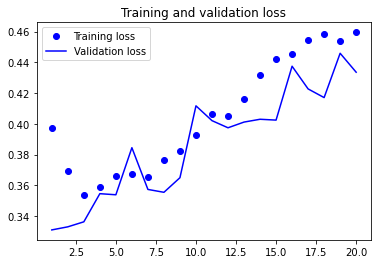

In [36]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [38]:
score3 = model.evaluate_generator(test_gen, 
                                 steps=test_steps, 
                                 verbose=1)

  9/930 [..............................] - ETA: 13s - loss: 0.5507

/var/folders/9_/z_nr8_hd32x51b1zx2flsn080000gn/T/ipykernel_13941/3400344105.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score3 = model.evaluate_generator(test_gen,


930/930 [==============================] - 13s 14ms/step - loss: 0.5326
4.71°C
1D CNN 모델 검증 MAE: 2.93°C
1D CNN 모델 test MAE: 2.92°C



In [40]:
print("1D CNN 결합 모델 검증 MAE: %.2f°C" %(std[1]*np.min(val_loss)))
print("1D CNN 결합 모델 test MAE: %.2f°C" %(std[1]*score3))

1D CNN 결합 모델 검증 MAE: 2.93°C
1D CNN 결합 모델 test MAE: 4.71°C


* 1D CNN 결합 모델 검증 MAE: 2.93°C
* 1D CNN 결합 모델 test MAE: 4.71°C

약간 성능이 떨어지지만 훨씬 빠르긴 하다(데이터 2배 더 많이 처리할 수 있었다.)